# Imports

In [182]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from helper_metrics import count_missing_district, count_missing_district_total, save_model, calculate_results, make_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
from sklearn.metrics         import mean_absolute_error, accuracy_score
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Load data

In [183]:
df = pd.read_csv("../data/imputed_data.csv").iloc[:,1:]
df

,date,district,total population,Under-Five Population,GAM,SAM,GAM Prevalence,SAM Prevalence,ipc,rainfall,ndvi,price_of_water,Total alarms,conflicts,prevalence_6lag,next_prevalence,month,increase,increase_numeric,district_encoded
0,2017-07-01,Adan Yabaal,65262.96000,13052.59200,4819.01697,1085.97565,0.36920,0.08320,0.18000,19.15667,0.21500,15.00000,2.16667,2.15000,NaN,0.35100,7,False,-0.01820,0
1,2017-07-01,Luuq,100476.76500,20095.35300,8673.15435,1306.19795,0.43160,0.06500,0.21000,24.24000,0.19333,15.00000,7.83333,1.50000,NaN,0.39260,7,False,-0.03900,59
2,2017-07-01,Buur Hakaba,165968.46000,33193.69200,11909.89669,3711.05477,0.35880,0.11180,0.35000,34.94500,0.34833,52.50000,6.16667,4.66667,NaN,0.28860,7,False,-0.07020,24
3,2017-07-01,Marka,282222.76500,56444.55300,20839.32897,4696.18681,0.36920,0.08320,0.17000,23.56500,0.29833,36.50000,11.83333,11.83333,NaN,0.35100,7,False,-0.01820,60
4,2017-07-01,Buuhoodle,71317.71000,14263.54200,4858.16241,1205.26930,0.34060,0.08450,0.37000,19.54000,0.21333,18.55116,2.33333,2.50000,NaN,0.20280,7,False,-0.13780,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,2021-07-01,Belet Xaawo,NaN,29314.59999,9820.00000,1310.00000,0.33499,0.04469,0.15000,36.71667,0.28500,21.68333,3.50000,1.20000,0.38353,NaN,7,NaN,NaN,15
652,2021-07-01,Jilib,NaN,28586.09073,11560.00000,2770.00000,0.40439,0.09690,0.11000,43.30000,0.45333,40.07000,6.16667,2.00000,0.31242,NaN,7,NaN,NaN,51
653,2021-07-01,Caynabo,NaN,16276.00000,3540.00000,270.00000,0.21750,0.01659,0.17000,21.15500,0.19500,19.08040,0.50000,1.00000,0.25746,NaN,7,NaN,NaN,29
654,2021-07-01,Rab Dhuure,NaN,15127.60000,6940.00000,1560.00000,0.45876,0.10312,0.07000,46.20667,0.21667,18.77839,0.16667,1.00000,0.50720,NaN,7,NaN,NaN,66


In [184]:
from helper_metrics import impute_score
crop = pd.read_csv("../data/semiyearly_chosen_columns_with_crop.csv")
so = crop["Sorghum"]
mai = crop["Maize"]
cow = crop["Cowpea"]

so.max()-so.min()

1915.835

In [185]:
impute_score(crop,features="Sorghum", method='mean', scale='0-1915')

RMSE for MEAN imputation in Sorghum: 282.163 
SCALE: 0-1915


In [186]:
impute_score(crop,features="Maize", method='mean', scale='0-1915')

RMSE for MEAN imputation in Maize: 346.983 
SCALE: 0-1915


In [187]:
impute_score(crop,features="Cowpea", method='mean', scale='0-1915')

RMSE for MEAN imputation in Cowpea: 478.361 
SCALE: 0-1915


In [188]:
np.mean([282.163, 346.983,478.361 ])

369.16900000000004

In [189]:
df = pd.read_csv("../data/imputed_semiyearly_with_crop.csv").iloc[:,1:]
df

,date,district,Unnamed: 0,prevalence,next_prevalence,prevalence_6lag,ndvi,ipc,population,month,district_encoded,increase,Cowpea,Maize,Sorghum,crop
0,2018-01-01,Burco,74,0.20280,0.22114,0.33594,0.18500,0.05000,534884.89500,1,21,True,456.46104,272.85837,272.85837,334.05926
1,2018-01-01,Xudur,75,0.48620,0.46890,0.48620,0.24833,0.14000,113853.10500,1,77,False,50.00000,500.00000,500.00000,350.00000
2,2018-01-01,Cadale,77,0.35100,0.28292,0.36920,0.22667,0.00000,48461.80500,1,27,False,12.00000,30.00000,30.00000,24.00000
3,2018-01-01,Qoryooley,78,0.35100,0.43638,0.36920,0.34667,0.09000,196309.48500,1,65,True,350.00000,600.00000,600.00000,516.66667
4,2018-01-01,Baardheere,79,0.39260,0.29726,0.43160,0.29333,0.00000,170132.26500,1,3,False,28.00000,1.68000,1.68000,10.45333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2021-01-01,Qoryooley,593,0.45939,0.45122,0.48013,0.51167,0.08000,207773.00000,1,65,False,320.00000,150.00000,150.00000,206.66667
262,2021-01-01,Borama,595,0.19121,0.27727,0.14129,0.25500,0.11000,453434.00000,1,17,True,400.19646,283.49961,283.49961,322.39856
263,2021-01-01,Kismaayo,596,0.37052,0.39348,0.36193,0.47833,0.22000,377653.00000,1,53,True,66.00000,294.80819,294.80819,218.53879
264,2021-01-01,Cadale,600,0.27595,0.28736,0.29052,0.39667,0.10000,61428.00000,1,27,True,60.00000,60.00000,60.00000,60.00000


In [190]:
# Sanity checks
df.isna().sum().sort_values(ascending=False)[:5]

date               0
district           0
Unnamed: 0         0
prevalence         0
next_prevalence    0
dtype: int64

In [191]:
len(df.district.unique())

38

# Create train and test sets
We must drop nan values in X for the RF model

In [192]:
y = df.next_prevalence.dropna()
X = df.select_dtypes(exclude=["object", "category"]).dropna(axis=1).iloc[:len(y),1:].drop(["prevalence","next_prevalence","prevalence_6lag","increase"],axis=1)
X

,ndvi,ipc,population,month,district_encoded,Cowpea,Maize,Sorghum,crop
0,0.18500,0.05000,534884.89500,1,21,456.46104,272.85837,272.85837,334.05926
1,0.24833,0.14000,113853.10500,1,77,50.00000,500.00000,500.00000,350.00000
2,0.22667,0.00000,48461.80500,1,27,12.00000,30.00000,30.00000,24.00000
3,0.34667,0.09000,196309.48500,1,65,350.00000,600.00000,600.00000,516.66667
4,0.29333,0.00000,170132.26500,1,3,28.00000,1.68000,1.68000,10.45333
...,...,...,...,...,...,...,...,...,...
261,0.51167,0.08000,207773.00000,1,65,320.00000,150.00000,150.00000,206.66667
262,0.25500,0.11000,453434.00000,1,17,400.19646,283.49961,283.49961,322.39856
263,0.47833,0.22000,377653.00000,1,53,66.00000,294.80819,294.80819,218.53879
264,0.39667,0.10000,61428.00000,1,27,60.00000,60.00000,60.00000,60.00000


# Subsets

In [193]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l: object) -> object:
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

In [194]:
38*4

152

# Cross Validation Training

In [195]:
# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 70

depth_min = 2
depth_max = 7

parameter_scores = []

for num_trees in tqdm(range(num_trees_min, num_trees_max)):

    for depth in range(depth_min, depth_max):

        # Investigate every subset of explanatory variables
        for features in subsets(X.columns):
            # First CV split. The 219 refers to the first 3 observations for the 73 districts in the data.
            Xtrain = X[:114][features].copy().values
            ytrain = y[:114]
            Xtest = X[114:152][features].copy().values
            ytest = y[114:152]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)

            # Second CV split. The 292 refers to the first 4 observations for the 73 districts in the data.
            Xtrain = X[:152][features].copy().values
            ytrain = y[:152]
            Xtest = X[152:190][features].copy().values
            ytest = y[152:190]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            # Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2) / 2

            # Store the mean MAE together with the used hyperparameters in list
            parameter_scores.append((mean_MAE, num_trees, depth, features))

# Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

'''------------SECTION FINAL EVALUATION--------------'''
y = df['next_prevalence'].values
X = df[best_model_columns].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Peform 190 on full data
Xtrain = X[:190]
ytrain = y[:190]
Xtest = X[190:]
ytest = y[190:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0, n_jobs=-1)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

100%|██████████| 6/6 [02:43<00:00, 27.29s/it]


In [196]:
# Calculate MAE
y_true = pd.Series(ytest[:-38])
y_pred = pd.Series(predictions[:-38])

#MAE = mean_absolute_error(ytest, predictions)
MAE = mean_absolute_error(y_true, y_pred)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = np.where(df.iloc[190:]["next_prevalence"] < df.iloc[190:]["prevalence"],0,1)
predicted_increase = np.where(predictions < df.iloc[190:]["prevalence"],0,1)

len(increase), len(predicted_increase)

(76, 76)

In [197]:
# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)



# Print model scores
print(f"MAE: {np.round(MAE,4)}, Accuracy: {np.round(acc,3)*100}%")

MAE: 0.0699, Accuracy: 80.30000000000001%


# Metrics

In [198]:
calculate_results(y_true=increase, y_pred=predicted_increase)

{'accuracy': 80.26315789473685,
 'precision': 0.8077605779153767,
 'recall': 0.8026315789473685,
 'f1': 0.7977839335180056}

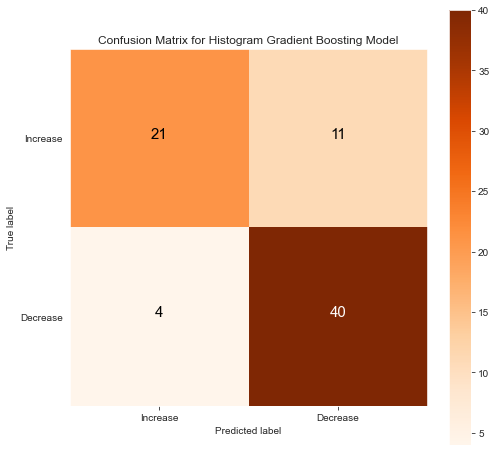

In [199]:
make_confusion_matrix(y_true=increase, y_pred=predicted_increase,classes=["Increase", "Decrease"],title="Confusion Matrix for Histogram Gradient Boosting Model", cmap=plt.cm.Oranges, figsize=(8,8))

In [200]:
save_model(model=clf, filename="baseline_imputed_crop.joblib")